Setting up the dataset and making sure it is cleaned up well

In [2]:
# Import statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [3]:
# Remove NaN functions

# Given a dataframe, removes all rows that have NaN data.
def remove_nan_rows(df):
    return df.dropna(axis = 0)

# Given a dataframe, replace all NaNs with a summary statistic of your choice.
def replace_nan_with_mean(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        if df_copy[col].isna().any():
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
    return df_copy

# Given a column of categorical data and an exhaustive list of labels, returns a one-hot encoding.
def one_hot_encode(name):
    column = df[name]
    labels = column.unique()
    return pd.get_dummies(column, prefix=column.name).reindex(columns=[f"{column.name}_{label}" for label in labels], fill_value=0)

def label_encode(column):
    # Get the unique labels in the column
    labels = column.unique()
    
    # Create a dictionary to map each label to a unique number
    label_dict = {label: idx for idx, label in enumerate(labels)}
    
    # Map the column values to the corresponding numbers
    return column.map(label_dict)


In [4]:
# Import Data set and clean 

df = pd.read_csv('atp_matches_2024.csv')
# Replace NaN values with mean
df = df.drop(columns=['winner_seed', 'winner_entry', 'loser_seed', 'loser_entry'])
df = remove_nan_rows(df)
print(df.columns)
print(df.shape)
df.head()

categorical_columns = ["tourney_name", "winner_name", "loser_name", "surface", "winner_hand"]
for name in categorical_columns:
    df[name + '_encoded'] = label_encode(df[name])
print(df.columns)

df.head()




Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_name',
       'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of',
       'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
       'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df',
       'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved',
       'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank',
       'loser_rank_points'],
      dtype='object')
(2761, 45)
Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_name', 'winner_hand',
       'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_name',
       'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of',
       'round', 'minu

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_name_encoded,winner_name_encoded,loser_name_encoded,surface_encoded,winner_hand_encoded
0,2024-0339,Brisbane,Hard,32,A,20240101,300,105777,Grigor Dimitrov,R,...,9.0,14.0,2570.0,8.0,3660.0,0,0,0,0,0
1,2024-0339,Brisbane,Hard,32,A,20240101,299,208029,Holger Rune,R,...,7.0,8.0,3660.0,39.0,1122.0,0,1,1,0,0
2,2024-0339,Brisbane,Hard,32,A,20240101,298,105777,Grigor Dimitrov,R,...,7.0,14.0,2570.0,55.0,902.0,0,0,2,0,0
3,2024-0339,Brisbane,Hard,32,A,20240101,297,208029,Holger Rune,R,...,5.0,8.0,3660.0,116.0,573.0,0,1,3,0,0
4,2024-0339,Brisbane,Hard,32,A,20240101,296,126128,Roman Safiullin,R,...,8.0,39.0,1122.0,44.0,1021.0,0,2,4,0,0


In [5]:
from sklearn.model_selection import train_test_split

# If dataset is large, we can use a subset
df = df.sample(n=1000, random_state=42)  # Use a random subset of 10,000 rows

# Split data into train, validation, and test sets (70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Display the split sizes
print(f"Training Set: {len(train_df)}")
print(f"Validation Set: {len(valid_df)}")
print(f"Test Set: {len(test_df)}")

Training Set: 700
Validation Set: 150
Test Set: 150


In [6]:
target_column = 'tourney_name_encoded'

# Extract features and target
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]
X_valid = valid_df.drop(columns=[target_column])
y_valid = valid_df[target_column]
X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

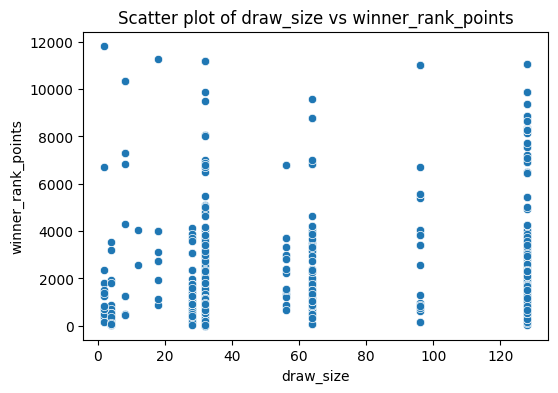

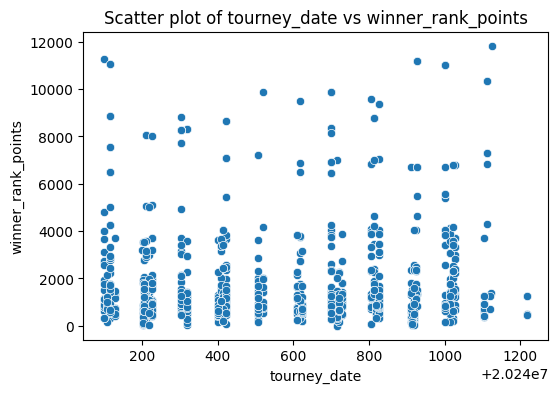

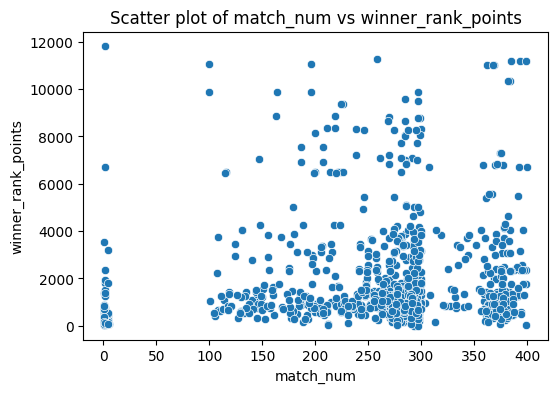

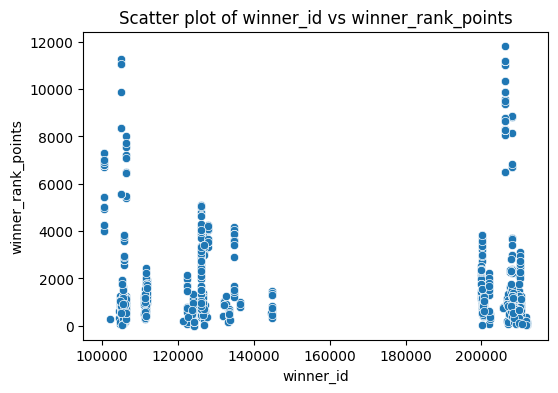

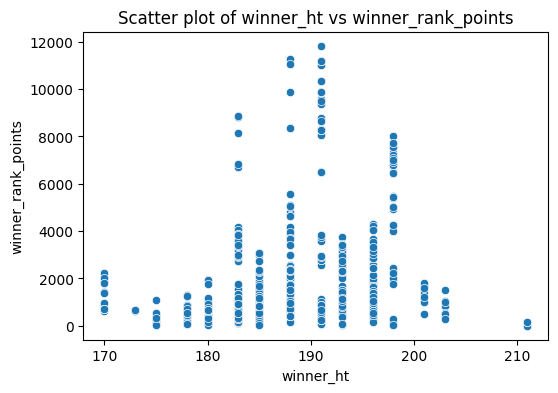

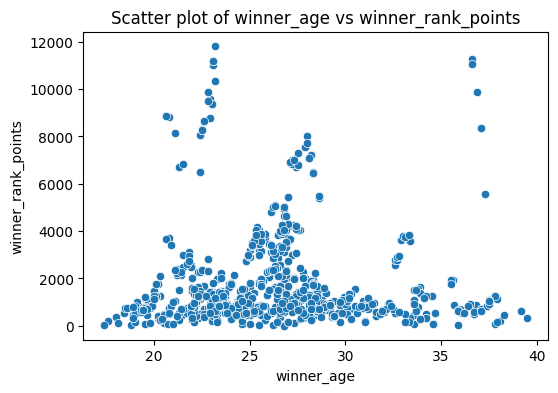

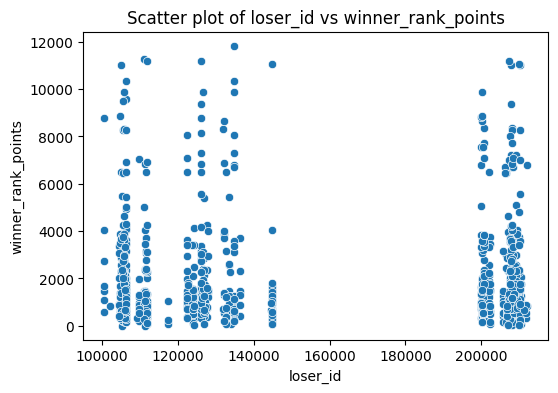

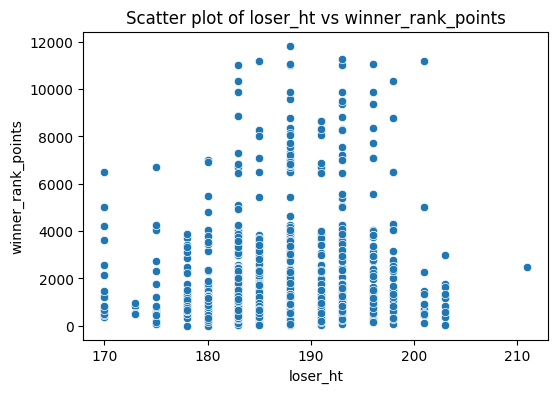

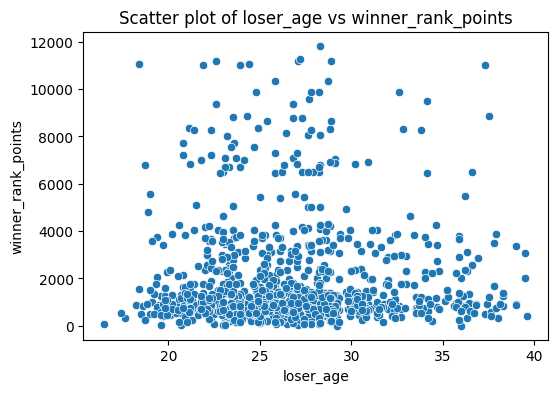

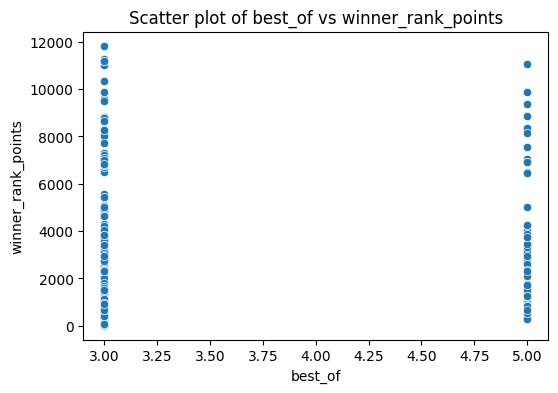

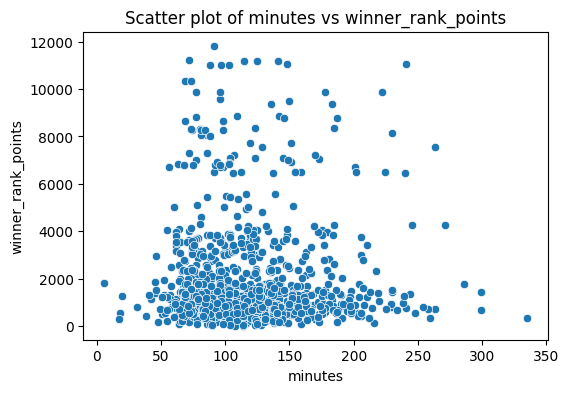

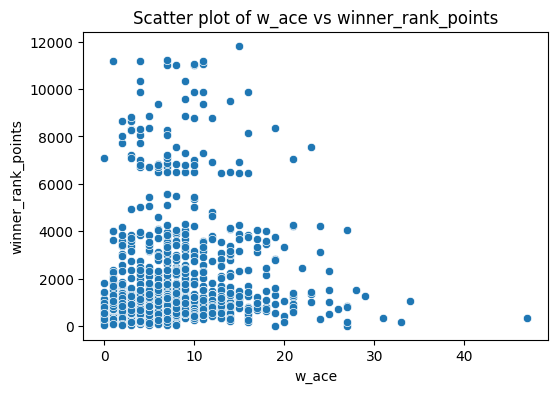

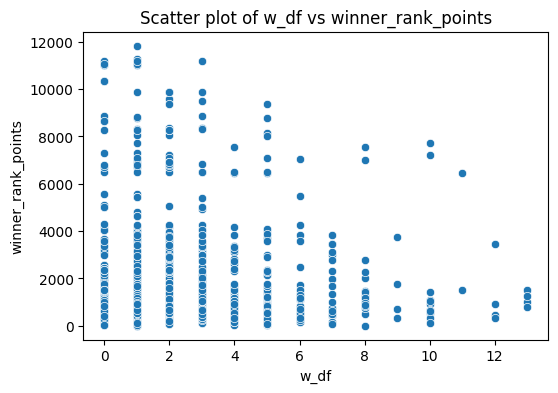

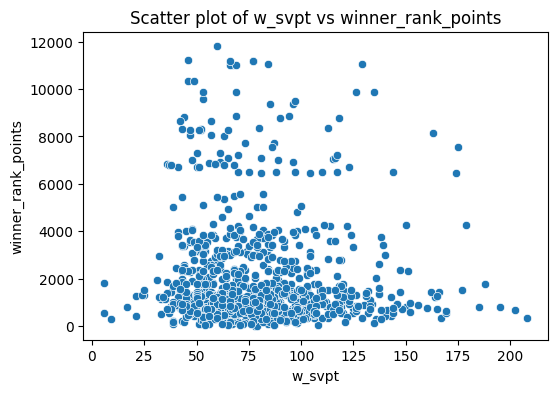

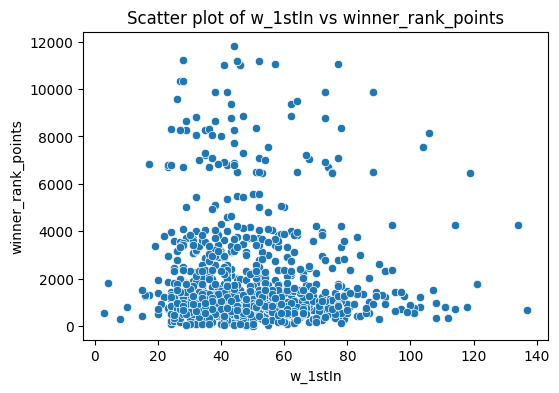

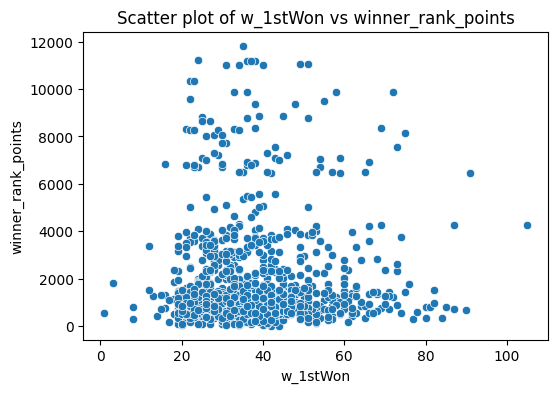

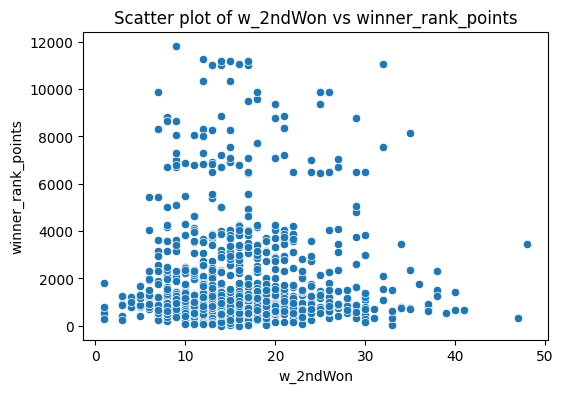

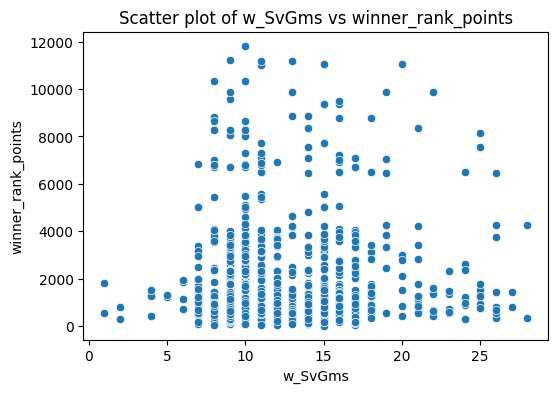

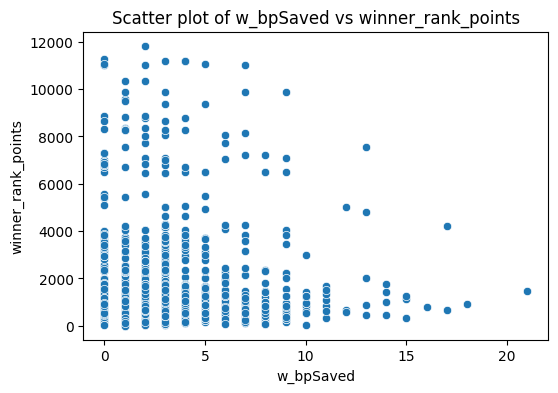

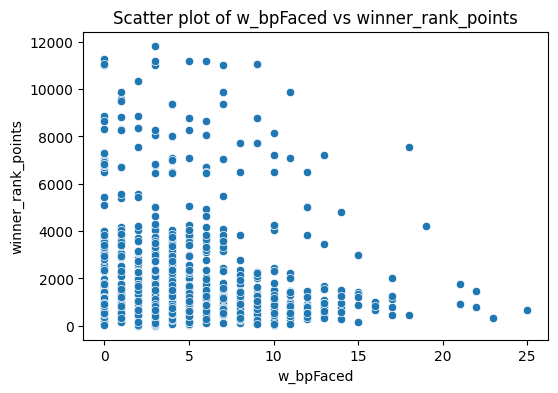

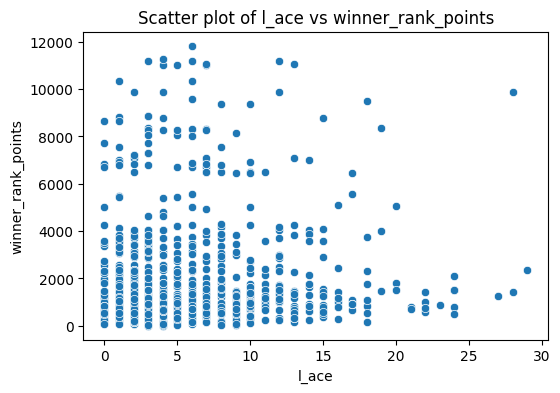

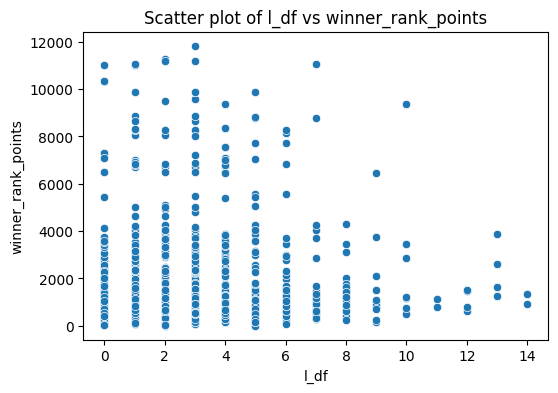

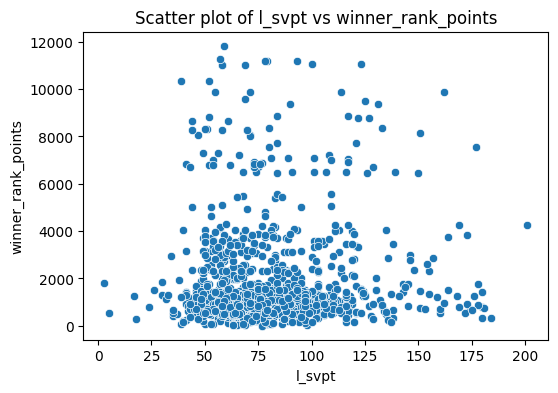

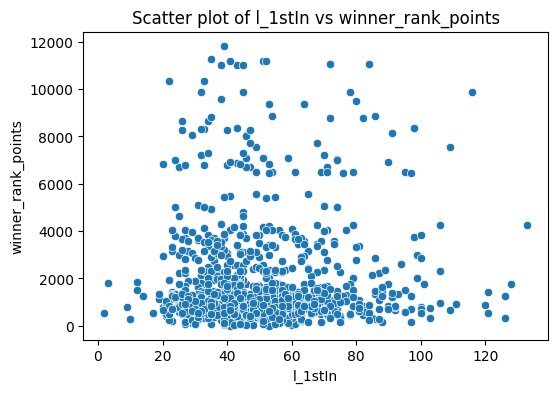

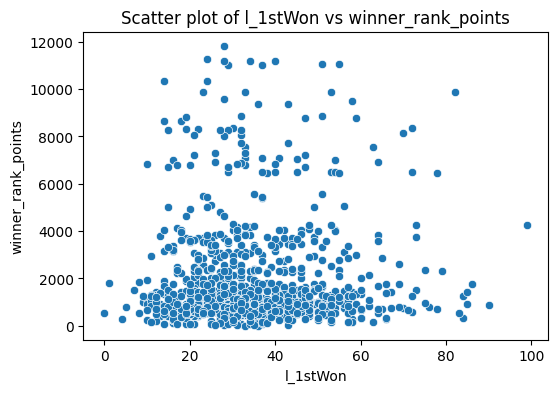

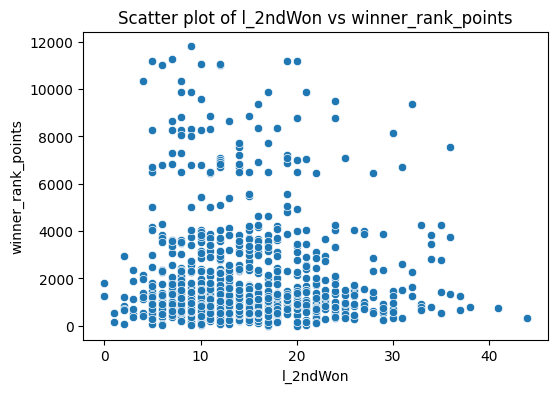

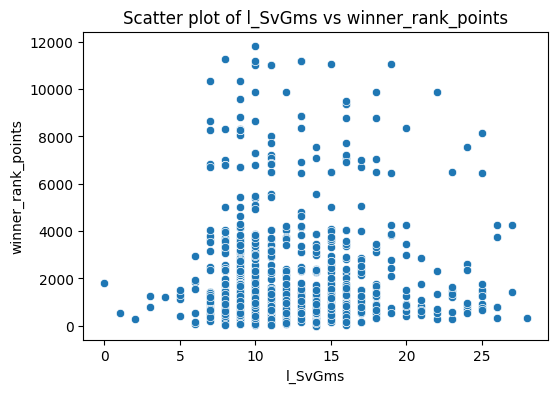

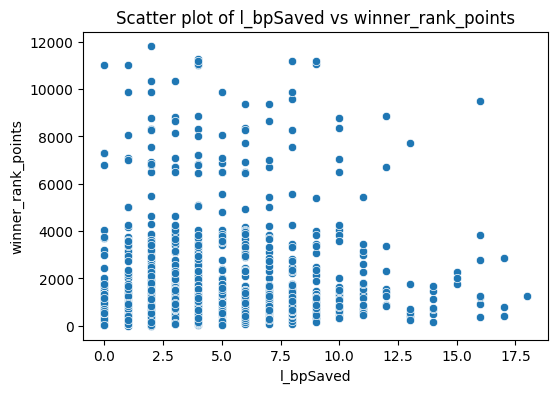

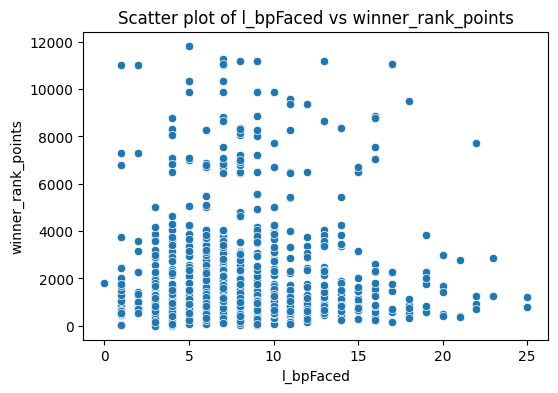

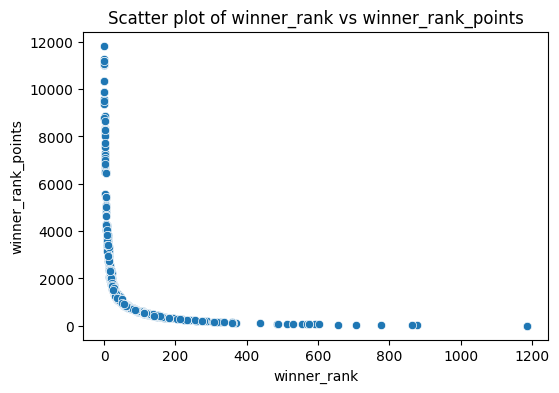

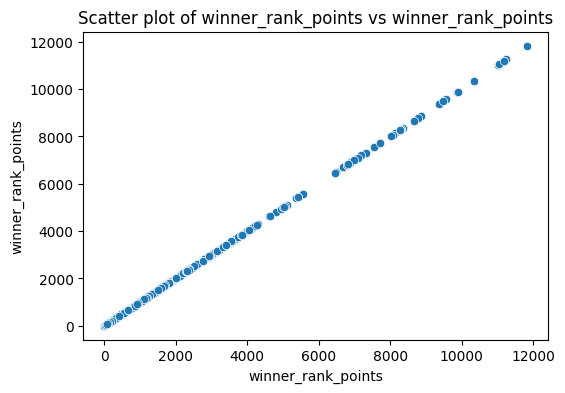

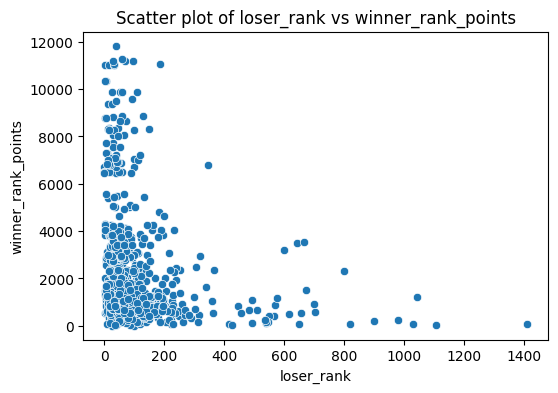

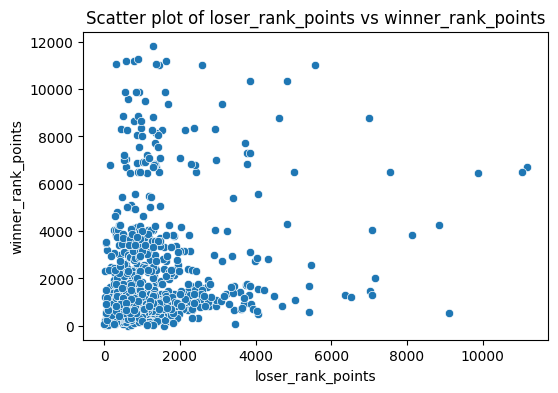

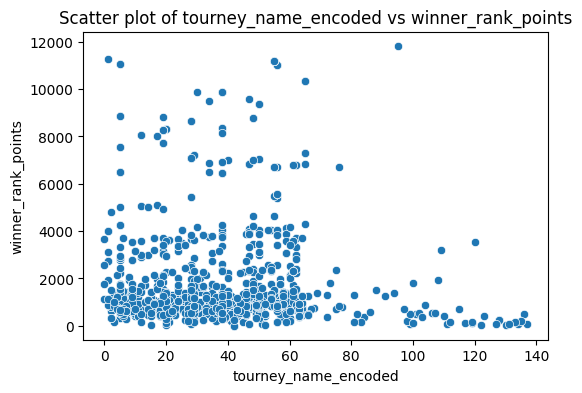

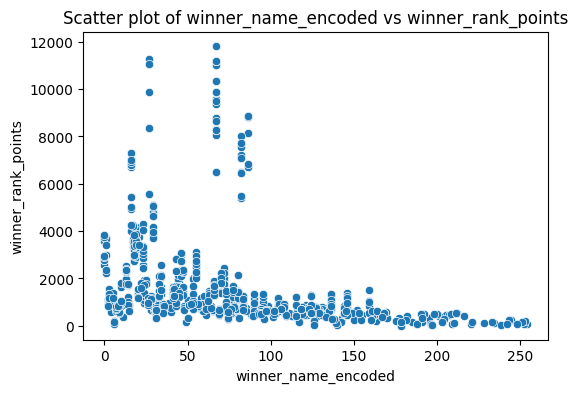

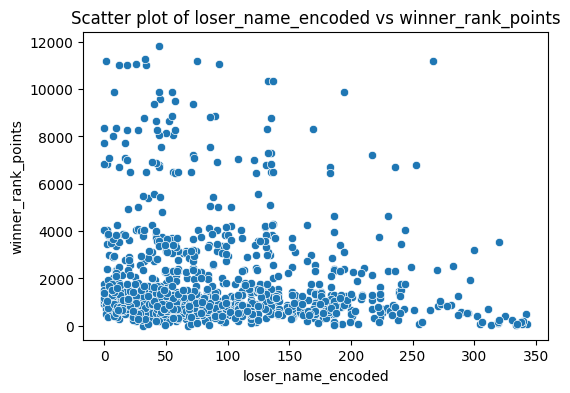

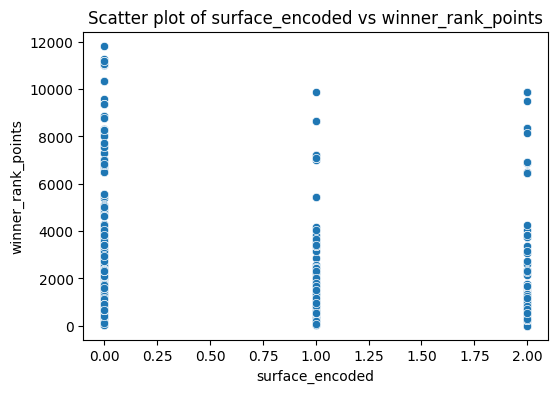

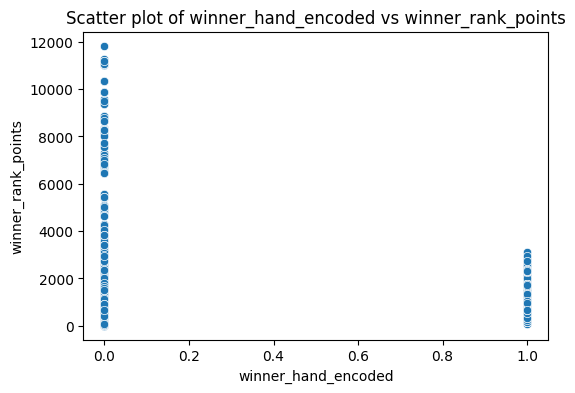

In [7]:
# Get features with highest correlation to target Winner Age
target_column = 'winner_rank_points'
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
high_corr_features = corr_matrix[target_column].abs().sort_values(ascending=False).index[1:4]  # Exclude the target itself

# Plot scatterplots
for feature in numeric_df:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df[target_column])
    plt.title(f'Scatter plot of {feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)
    plt.show()

In [30]:
correlation_matrix = numeric_df.corr()
print(correlation_matrix)


                      draw_size  tourney_date  match_num  winner_id  \
draw_size              1.000000     -0.154870  -0.275089  -0.005985   
tourney_date          -0.154870      1.000000   0.302442   0.069274   
match_num             -0.275089      0.302442   1.000000   0.029559   
winner_id             -0.005985      0.069274   0.029559   1.000000   
winner_ht              0.130041      0.043942   0.059251  -0.137124   
winner_age            -0.011315     -0.042956  -0.013334  -0.823438   
loser_id              -0.049402      0.044949  -0.034205  -0.079941   
loser_ht               0.082871     -0.067510  -0.071018  -0.058471   
loser_age              0.016487      0.037133   0.038314   0.083299   
best_of                0.568367     -0.045909  -0.428741   0.040950   
minutes                0.320494     -0.079088  -0.277072   0.004058   
w_ace                  0.185628      0.155485  -0.102079  -0.005630   
w_df                   0.194615      0.046702  -0.147835   0.064626   
w_svpt

In [50]:
feature = "winner_rank_points"
target_column = "winner_rank"
plt.title(f'Scatter plot of {feature} vs {target_column}')
plt.xlabel(feature)
plt.ylabel(target_column)
sns.scatterplot(x=df["winner_rank"], y=df["winner_rank_points"])
plt.savefig(f'../cds-onboarding-tennis/ms3plots/rank_points_vs_rank.png')


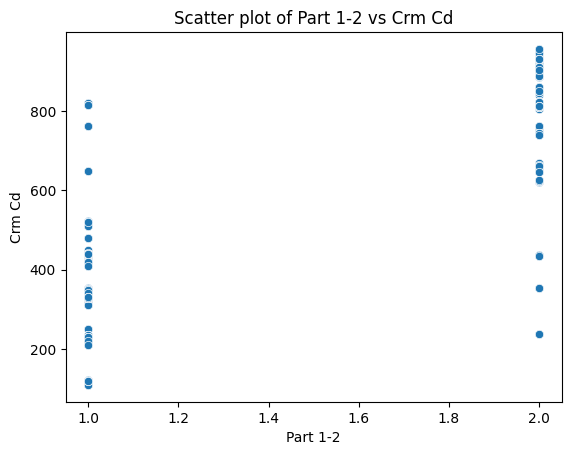

In [73]:
feature = "Part 1-2"
target_column = "Crm Cd"
plt.title(f'Scatter plot of {feature} vs {target_column}')
plt.xlabel(feature)
plt.ylabel(target_column)
sns.scatterplot(x=df[feature], y=df[target_column])
plt.savefig(f'../ms3plots/part_vs_crm.png')


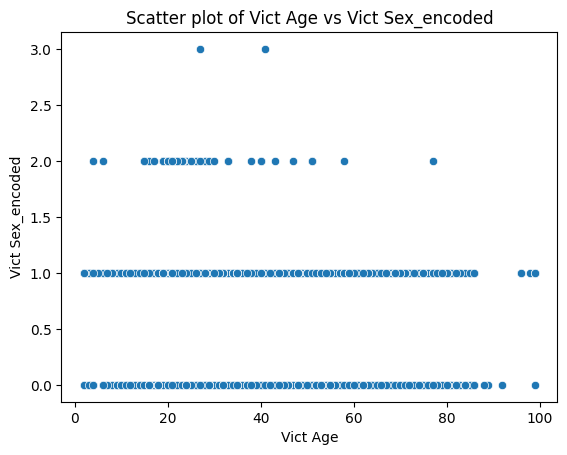

In [74]:
feature = "Vict Age"
target_column = "Vict Sex_encoded"
plt.title(f'Scatter plot of {feature} vs {target_column}')
plt.xlabel(feature)
plt.ylabel(target_column)
sns.scatterplot(x=df[feature], y=df[target_column])
plt.savefig(f'../ms3plots/age_vs_sex.png')


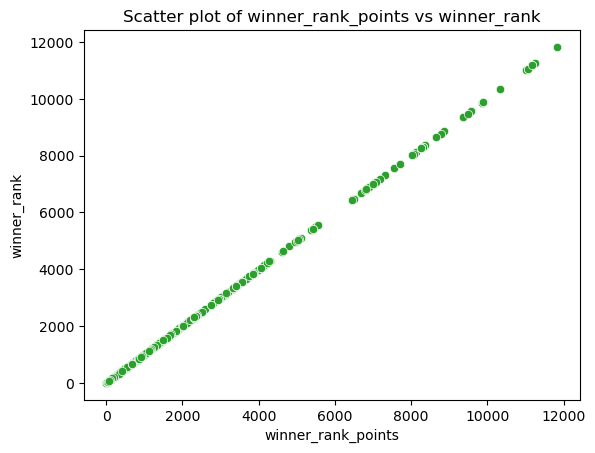

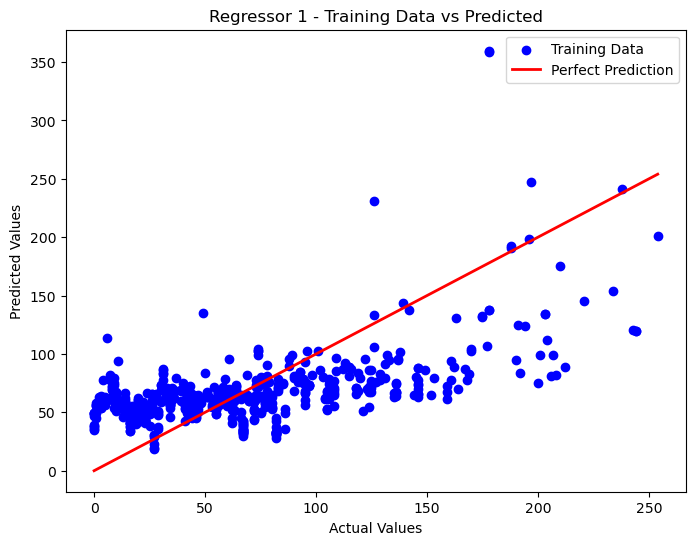

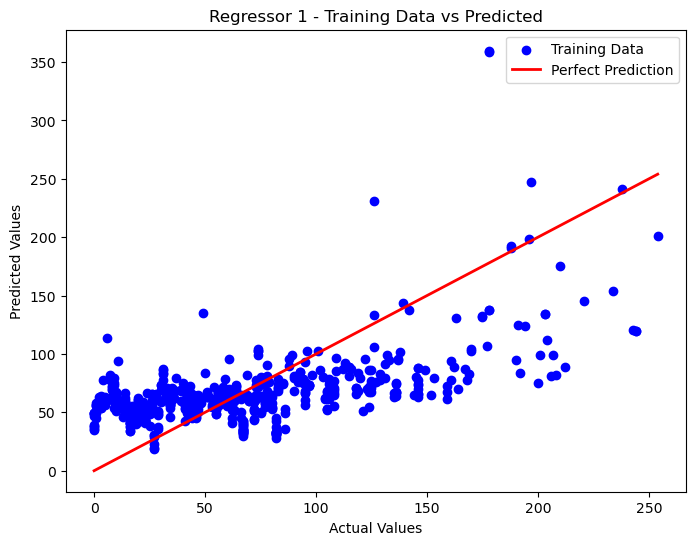

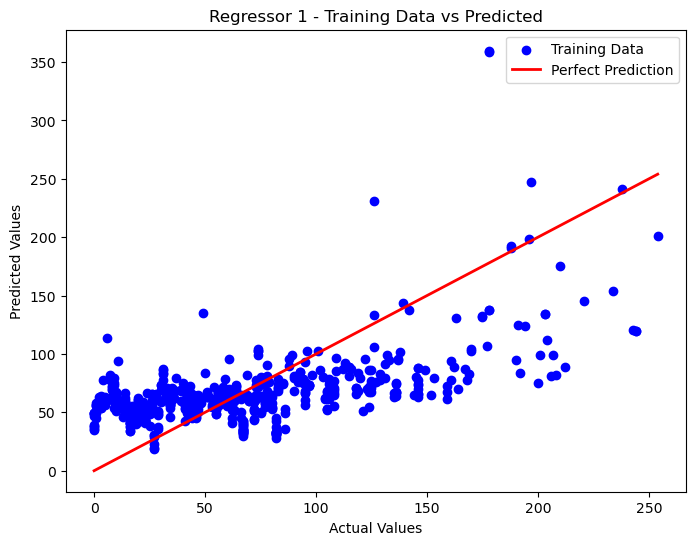

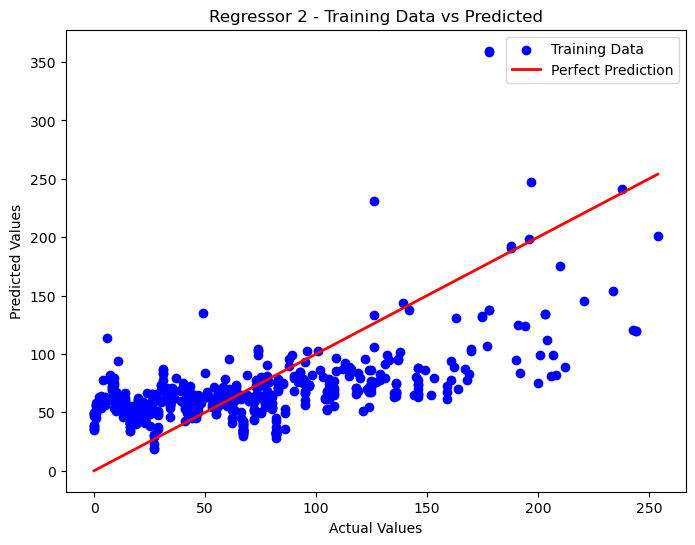

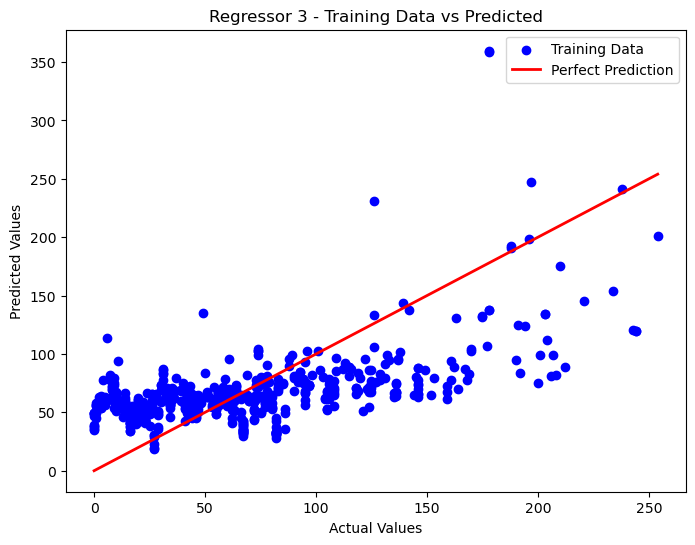

     Regressor  Training MSE  Validation MSE
0  Regressor 1   1713.503342     1990.809971
1  Regressor 2   1713.503342     1990.809971
2  Regressor 3   1713.503342     1990.809971


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- draw_size
- winner_rank


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features_regressor_1 = ['winner_age', 'winner_rank_points']
features_regressor_2 = ['loser_age', 'loser_rank_points']
features_regressor_3 = ['draw_size', 'winner_rank']

target_column = 'winner_name_encoded' #We have little to no correlation so we are just playing around with data at this point :(

X = df[features_regressor_1 + features_regressor_2 + features_regressor_3]  # Combine all features
y = df[target_column]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def train_evaluate_regressor(X_train, y_train, X_val, y_val, model_name) :
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)


    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_train_pred, color='blue', label='Training Data')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Training Data vs Predicted')
    plt.legend()
    # plt.savefig(f"../ms3plots/{model_name}_training_plot.png")
    plt.show()

    #mse
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    return model, train_mse, val_mse


regressor_1, train_mse_1, val_mse_1 = train_evaluate_regressor(X_train, y_train, X_val, y_val, 'Regressor 1')
regressor_2, train_mse_2, val_mse_2 = train_evaluate_regressor(X_train, y_train, X_val, y_val, 'Regressor 2')
regressor_3, train_mse_3, val_mse_3 = train_evaluate_regressor(X_train, y_train, X_val, y_val, 'Regressor 3')
# Create a table of training and validation errors
error_table = pd.DataFrame({
    'Regressor': ['Regressor 1', 'Regressor 2', 'Regressor 3'],
    'Training MSE': [train_mse_1, train_mse_2, train_mse_3],
    'Validation MSE': [val_mse_1, val_mse_2, val_mse_3]
})



error_table = pd.DataFrame({
    'Regressor': ['Regressor 1', 'Regressor 2', 'Regressor 3'],
    'Training MSE': [train_mse_1, train_mse_2, train_mse_3],
    'Validation MSE': [val_mse_1, val_mse_2, val_mse_3]
})

print(error_table)

# picking a random model and testing the MSE
best_regressor_index = error_table['Validation MSE'].idxmin()
best_regressor_name = error_table['Regressor'][best_regressor_index]
best_regressor = [regressor_1, regressor_2, regressor_3]
best_model = best_regressor[best_regressor_index]


# Test the best model on the test set
y_test_pred = best_model.predict(X_test[['winner_age', 'winner_rank_points', 'loser_age', 'loser_rank_points', 'draw_size','winner_rank']])
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Test MSE of Best Model: {test_mse}")
